# 02-tumor-growth


2. **Tumor Growth and Angiogenesis Model**

i. Motivation:
- Understanding cancer progression
- Testing therapeutic strategies
- Modeling blood vessel formation
- Studying drug delivery

AI support: Provide real-world examples, generate case studies, explain clinical relevance.

ii. Conceptual/Mathematical Description:
- Reaction-diffusion equations for tumor cells
- Nutrient and growth factor diffusion
- Blood vessel sprouting rules
- Cell death and proliferation rates

AI support: Visualize mathematical concepts, explain partial differential equations, generate simplified examples.

iii. Implementation:
- Grid-based simulation using NumPy arrays
- Finite difference method for diffusion
- Agent-based model for vessels
- Integration with cellular automata

AI support: Suggest efficient data structures, optimize numerical methods, help with parallel processing.

iv. Simulation/Visualization:
- 2D/3D visualization of tumor growth
- Blood vessel network formation
- Nutrient concentration fields
- Treatment response

AI support: Generate visualization code, suggest animation techniques, create interactive exploration tools.

v. Going Deeper:
- Add immune system response
- Include drug resistance
- Model metastasis
- Incorporate genetic heterogeneity

AI support: Find relevant research papers, suggest model extensions, help with parameter optimization.

----


The project can be implemented with varying levels of complexity, making it suitable for different skill levels. Key Python libraries to use include:

- NumPy/SciPy for numerical computations
- Matplotlib/Plotly for visualization
- NetworkX for network analysis
- Pandas for data management
- SymPy for symbolic mathematics
- scikit-learn for machine learning components

AI can significantly enhance the learning experience by:
1. Generating explanatory content and tutorials
2. Helping with code implementation and debugging
3. Suggesting optimizations and best practices
4. Finding relevant literature and examples
5. Creating interactive visualization tools
6. Assisting with parameter optimization
7. Generating test cases and validation data
8. Helping with model extension and modification


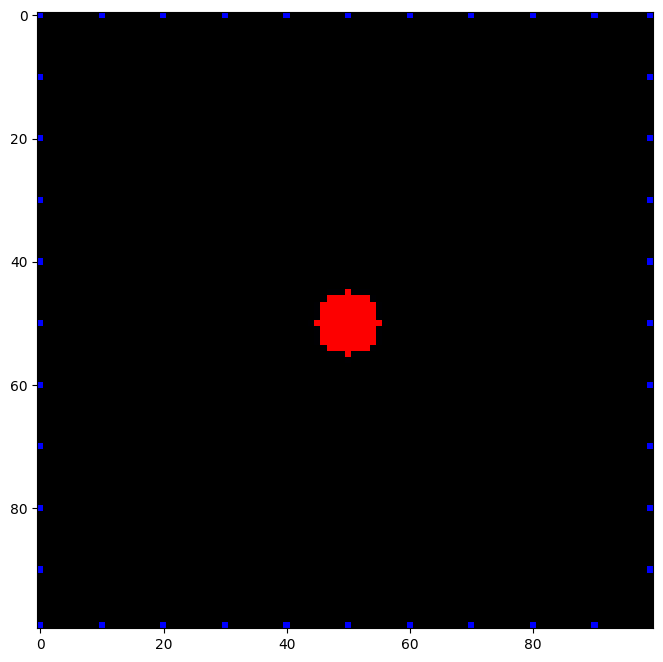

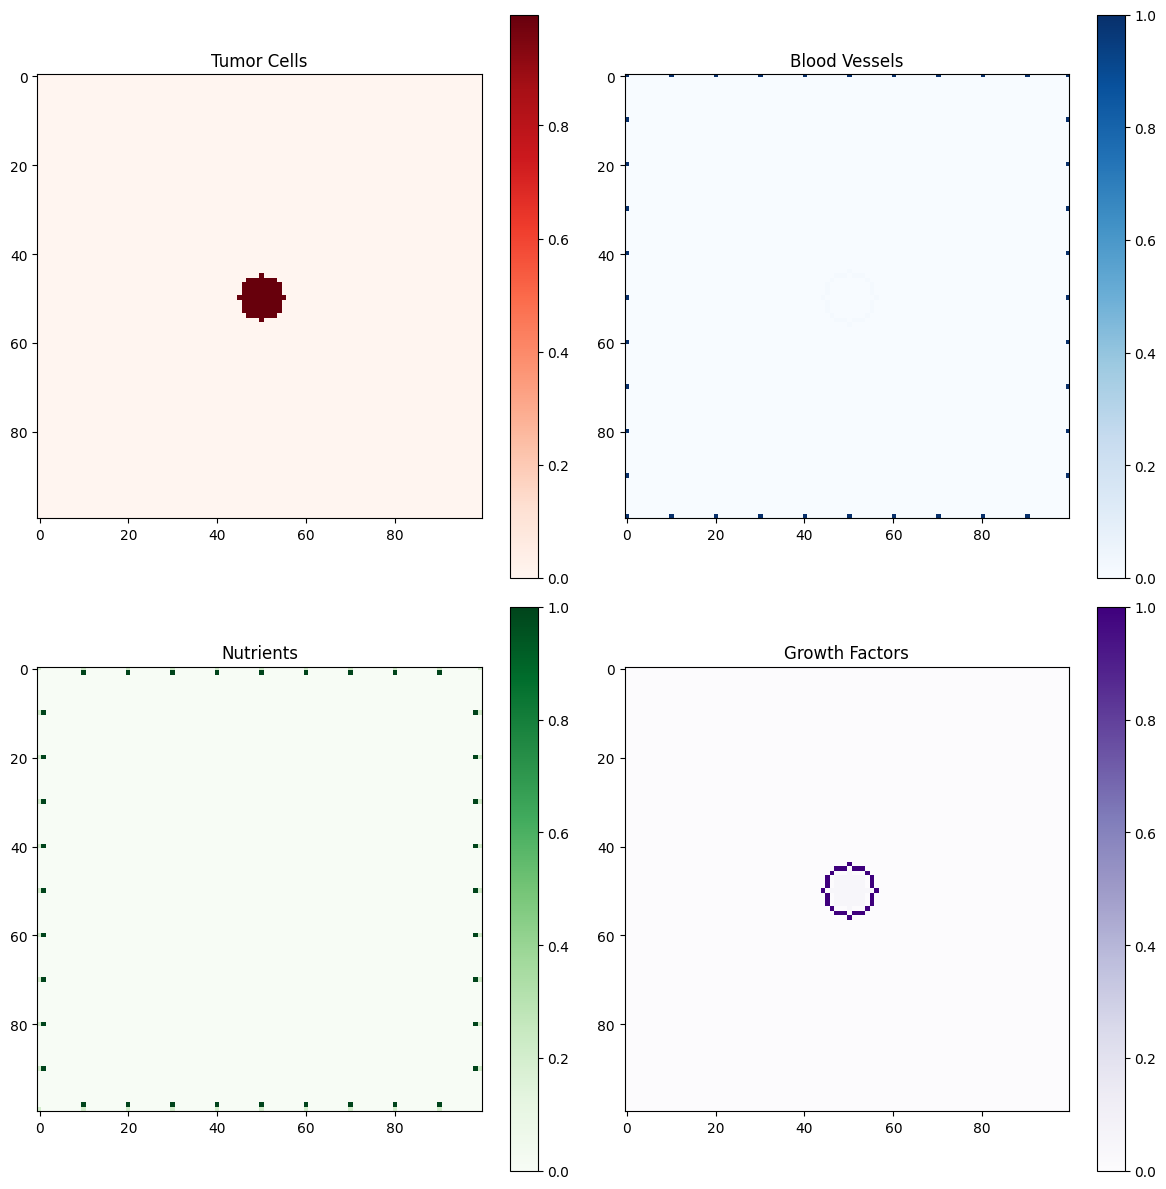

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import convolve

class TumorAngiogenesisModel:
    def __init__(self, grid_size=100, dx=0.01):
        self.grid_size = grid_size
        self.dx = dx
        
        # Initialize grids
        self.tumor_cells = np.zeros((grid_size, grid_size))
        self.vessels = np.zeros((grid_size, grid_size))
        self.nutrients = np.zeros((grid_size, grid_size))
        self.growth_factors = np.zeros((grid_size, grid_size))
        
        # Parameters
        self.D_n = 0.1  # Nutrient diffusion coefficient
        self.D_g = 0.05  # Growth factor diffusion coefficient
        self.proliferation_rate = 0.1
        self.death_rate = 0.02
        self.vessel_growth_rate = 0.15
        self.nutrient_consumption_rate = 0.1
        self.growth_factor_production_rate = 0.2
        
        # Initialize tumor seed
        center = grid_size // 2
        radius = 5
        Y, X = np.ogrid[:grid_size, :grid_size]
        dist_from_center = np.sqrt((X - center)**2 + (Y - center)**2)
        self.tumor_cells[dist_from_center <= radius] = 1.0
        
        # Initialize some vessels
        self.vessels[0, ::10] = 1.0
        self.vessels[-1, ::10] = 1.0
        self.vessels[::10, 0] = 1.0
        self.vessels[::10, -1] = 1.0

    def diffuse(self, field, D, dt):
        """Diffusion using finite differences"""
        laplacian = np.zeros_like(field)
        dx2 = self.dx**2
        
        # 5-point stencil for Laplacian
        laplacian[1:-1, 1:-1] = (
            field[1:-1, 2:] + field[1:-1, :-2] +
            field[2:, 1:-1] + field[:-2, 1:-1] -
            4 * field[1:-1, 1:-1]
        ) / dx2
        
        return field + D * dt * laplacian

    def update(self, dt=0.1):
        # Diffuse nutrients from vessels
        self.nutrients = self.diffuse(self.nutrients, self.D_n, dt)
        self.nutrients += self.vessels * dt  # Source term from vessels
        self.nutrients -= self.tumor_cells * self.nutrient_consumption_rate * dt
        np.clip(self.nutrients, 0, 1, out=self.nutrients)
        
        # Diffuse growth factors
        self.growth_factors = self.diffuse(self.growth_factors, self.D_g, dt)
        self.growth_factors += (
            self.tumor_cells * 
            (1 - self.nutrients) * 
            self.growth_factor_production_rate * 
            dt
        )
        np.clip(self.growth_factors, 0, 1, out=self.growth_factors)
        
        # Update tumor cells
        proliferation = (
            self.tumor_cells * 
            (1 - self.tumor_cells) * 
            self.nutrients * 
            self.proliferation_rate * 
            dt
        )
        death = self.tumor_cells * (1 - self.nutrients) * self.death_rate * dt
        self.tumor_cells += proliferation - death
        np.clip(self.tumor_cells, 0, 1, out=self.tumor_cells)
        
        # Update vessels (angiogenesis)
        vessel_growth = (
            (1 - self.vessels) * 
            self.growth_factors * 
            self.vessel_growth_rate * 
            dt
        )
        self.vessels += vessel_growth
        np.clip(self.vessels, 0, 1, out=self.vessels)

    def visualize(self, show_all=True):
        if show_all:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
            
            # Tumor cells
            im1 = ax1.imshow(self.tumor_cells, cmap='Reds')
            ax1.set_title('Tumor Cells')
            plt.colorbar(im1, ax=ax1)
            
            # Vessels
            im2 = ax2.imshow(self.vessels, cmap='Blues')
            ax2.set_title('Blood Vessels')
            plt.colorbar(im2, ax=ax2)
            
            # Nutrients
            im3 = ax3.imshow(self.nutrients, cmap='Greens')
            ax3.set_title('Nutrients')
            plt.colorbar(im3, ax=ax3)
            
            # Growth factors
            im4 = ax4.imshow(self.growth_factors, cmap='Purples')
            ax4.set_title('Growth Factors')
            plt.colorbar(im4, ax=ax4)
            
        else:
            plt.figure(figsize=(8, 8))
            combined = np.zeros((self.grid_size, self.grid_size, 3))
            combined[:, :, 0] = self.tumor_cells  # Red channel
            combined[:, :, 2] = self.vessels      # Blue channel
            plt.imshow(combined)
            plt.title('Tumor (red) and Vessels (blue)')
        
        plt.tight_layout()
        plt.show()

def animate_growth(model, steps=100, interval=100):
    fig, ax = plt.subplots(figsize=(8, 8))
    combined = np.zeros((model.grid_size, model.grid_size, 3))
    combined[:, :, 0] = model.tumor_cells
    combined[:, :, 2] = model.vessels
    im = ax.imshow(combined)
    
    def update(frame):
        model.update()
        combined = np.zeros((model.grid_size, model.grid_size, 3))
        combined[:, :, 0] = model.tumor_cells
        combined[:, :, 2] = model.vessels
        im.set_array(combined)
        return [im]
    
    anim = FuncAnimation(
        fig, update, frames=steps, interval=interval, blit=True
    )
    plt.show()
    return anim

# Example usage
if __name__ == "__main__":
    # Create model instance
    model = TumorAngiogenesisModel(grid_size=100)
    
    # Run simulation and create animation
    animate_growth(model, steps=200, interval=50)
    
    # Show final state with all fields
    model.visualize(show_all=True)